# Email Spam Dectecting Model

Email spam, a persistent nuisance in our digital lives, poses significant challenges for both users and email service providers. In response to this, email spam detection has become a critical component of modern email systems. This project focuses on the development of an email spam detection system that employs cutting-edge Natural Language Processing (NLP) techniques and machine learning models, including Random Forest, Support Vector Classifier (SVC), and k-Nearest Neighbors (KNN). Our objective is to enhance the filtering and identification of spam emails, ensuring that legitimate messages make their way into the inbox while unwanted spam is effectively quarantined. This project promises to improve email security and user experience by employing advanced technology to combat the persistent problem of email spam.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score


### Loading Dataset

Dataset:https://www.kaggle.com/datasets/mfaisalqureshi/spam-email

In [2]:
data=pd.read_csv(r"C:\Users\babua\OneDrive\Desktop\project 2\spam.csv")
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Data Exploration

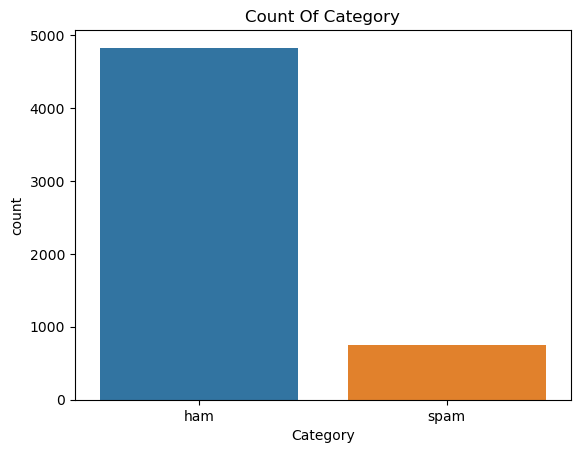

In [4]:
#counting Category
sns.countplot(x=data.Category)
plt.title("Count Of Category")
plt.show()

### Feature Engineering

Creating 3 new columns containg count of sentence words and characters 

In [5]:
data['characters']=data.Message.apply(len)
data['sentence']=data['Message'].apply(lambda x:nltk.sent_tokenize(x)).apply(len)
data['words']=data['Message'].apply(lambda x:nltk.word_tokenize(x)).apply(len)

In [6]:
data.describe()

,characters,sentence,words
count,5572.000000,5572.000000,5572.000000
mean,80.368988,2.004666,18.826992
std,59.926946,1.539516,13.853616
min,2.000000,1.000000,1.000000
25%,35.750000,1.000000,9.000000
50%,61.000000,2.000000,15.000000
75%,122.000000,2.000000,27.000000
max,910.000000,38.000000,220.000000


we can see some outliers by analysing the output of describe

C:\Users\babua\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


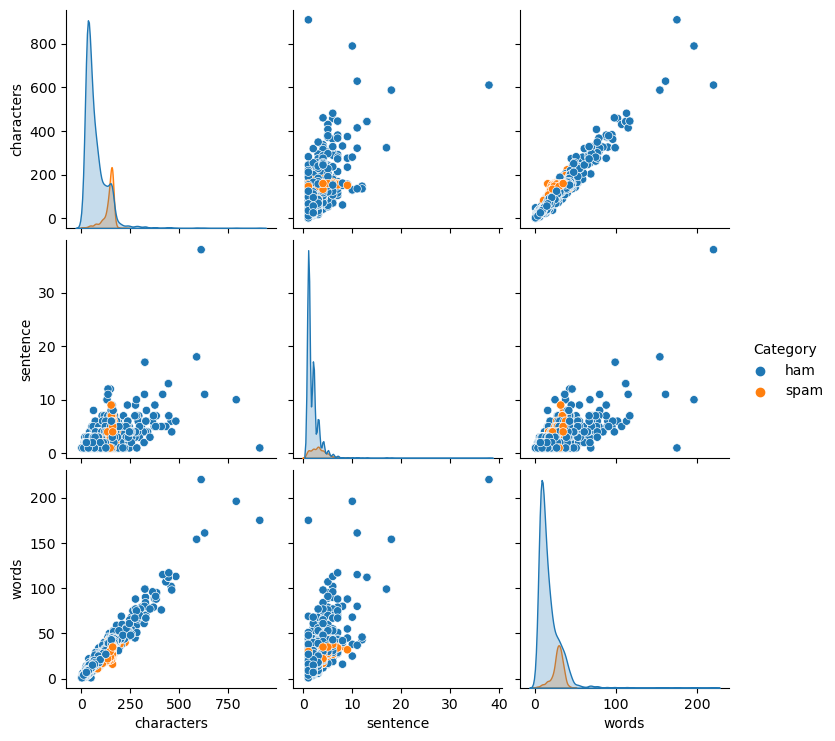

In [7]:
sns.pairplot(data=data,hue='Category')
plt.show()

In [8]:
#removing outliers
data=data[data.characters<300]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5530 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Category    5530 non-null   object
 1   Message     5530 non-null   object
 2   characters  5530 non-null   int64 
 3   sentence    5530 non-null   int64 
 4   words       5530 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 259.2+ KB


In [9]:
data.describe()

,characters,sentence,words
count,5530.000000,5530.000000,5530.000000
mean,77.827125,1.954430,18.194756
std,51.311395,1.320054,11.443502
min,2.000000,1.000000,1.000000
25%,35.000000,1.000000,9.000000
50%,61.000000,1.000000,15.000000
75%,121.000000,2.000000,27.000000
max,298.000000,12.000000,88.000000


C:\Users\babua\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


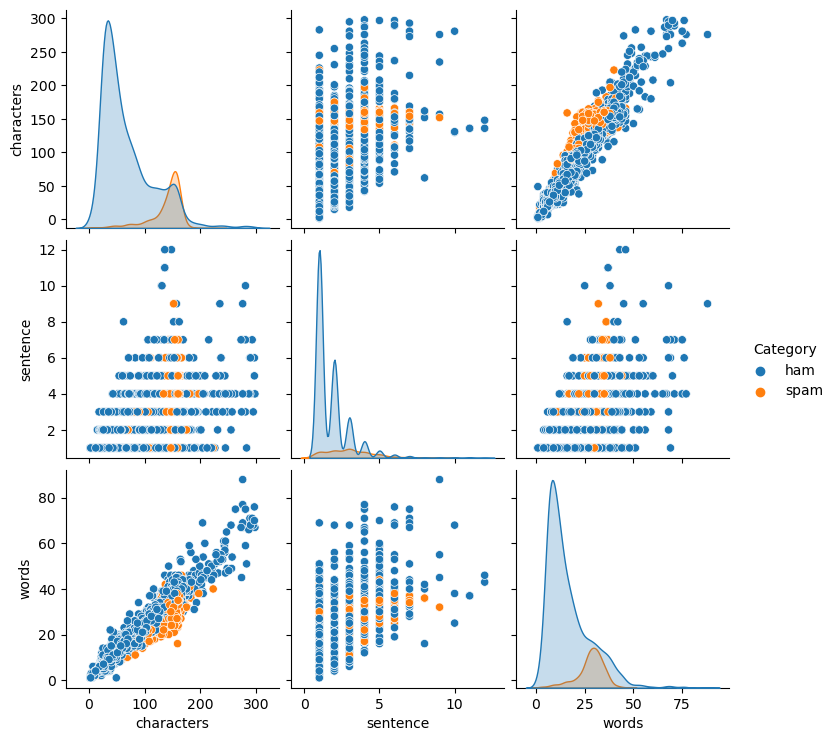

In [10]:
sns.pairplot(data=data,hue='Category')
plt.show()

### Data Preprocessing

Cleaning Text<br>
Removing all special characters and numbers from the list


In [11]:
print(data.Message[:5],sep='\n')

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: Message, dtype: object


In [12]:
def text_clean(text):
    mail=re.sub('[^a-zA-Z]'," ",text)
    mail=mail.lower()
    return mail
data['clean_text']=data.Message.apply(text_clean)


In [13]:
print(data['clean_text'][:5],sep='\n')

0    go until jurong point  crazy   available only ...
1                        ok lar    joking wif u oni   
2    free entry in   a wkly comp to win fa cup fina...
3    u dun say so early hor    u c already then say   
4    nah i don t think he goes to usf  he lives aro...
Name: clean_text, dtype: object


#### Tokenization

In [14]:
def tokenize(text):
    tokenized_text=nltk.word_tokenize(text)
    return tokenized_text
data['tokenized_text']=data['clean_text'].apply(tokenize)
print(data['tokenized_text'][:5],sep='\n')


0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: tokenized_text, dtype: object


#### Stopwords Removing

In [15]:
def stopword_remover(text):
    stopword=set(stopwords.words('english'))
    filtered_word=[i for i in text if i not in stopword]
    return filtered_word
data['Nostopword']=data['tokenized_text'].apply(stopword_remover)

In [16]:
print(data['Nostopword'][:5],sep='\n')


0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
Name: Nostopword, dtype: object


#### Lemmatization

In [17]:
lemmatizer=WordNetLemmatizer()
def lemmatized_word(text):
    lemmas=[lemmatizer.lemmatize(word,pos='v') for word in text]
    return lemmas 
data['lemmatized_word']=data['Nostopword'].apply(lemmatized_word)


In [18]:
print(data['lemmatized_word'][:5],sep='\n')

0    [go, jurong, point, crazy, available, bugis, n...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, live, around, though]
Name: lemmatized_word, dtype: object


### Vectorize

In [19]:
#creating corpus
corpus=[]
for i in data['lemmatized_word']:
    mail=' '.join([row for row in i])
    corpus.append(mail)
#changing text data into numbers
tfidf=TfidfVectorizer()
X=tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

### Label Encoding Target

In [20]:
le=LabelEncoder()
data.Category=le.fit_transform(data.Category)
data.head()

,Category,Message,characters,sentence,words,clean_text,tokenized_text,Nostopword,lemmatized_word
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24,go until jurong point crazy available only ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,2,8,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37,free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,1,13,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15,nah i don t think he goes to usf he lives aro...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


### Model Building

In [21]:
y=data.Category
#splitting training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=10)

#### Finding Best Model

In [22]:
print("Accuracy Score \n")
rf=RandomForestClassifier()
knn=KNeighborsClassifier()
svc=SVC()
mnb=MultinomialNB()
model={'RandomForestClassifier':rf,'KNeighborsClassifier':knn,'SVC':svc,'MultinomialNB':mnb}
for name,classifier in model.items():
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    score=accuracy_score(y_pred,y_test)
    print(name,' : ',score)

Accuracy Score 

RandomForestClassifier  :  0.9775849602313811
KNeighborsClassifier  :  0.9088937093275488
SVC  :  0.9768618944323934
MultinomialNB  :  0.9645697758496024


In [23]:
#checking accuracy again using cross validation
print("Cross Validation \n")
for key,value in model.items():
    cv_score=cross_val_score(value,X_train,y_train,scoring='accuracy',cv=10)
    print(key,' : ',cv_score.mean())

Cross Validation 

RandomForestClassifier  :  0.975887317385484
KNeighborsClassifier  :  0.9100576217915138
SVC  :  0.9754053896746406
MultinomialNB  :  0.9633490483673827


from the accuracy test and cross validation svc and random forest have good scores.Here i choose svc to build my model

Building model using svc 

In [25]:
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In conclusion, the evaluation of machine learning models for email spam detection in the project has yielded promising results. RandomForestClassifier and Support Vector Classifier (SVC) demonstrated high accuracy scores, making them strong contenders for building an effective spam detection system. KNeighborsClassifier, while slightly less accurate, could still be valuable in certain contexts, and MultinomialNB remains a computationally efficient option. Here I choose SVC as the final model.